In [3]:
# ===================== 1. SETUP & IMPORTS =====================

import os
import time
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import time
from datetime import timedelta


from scipy.signal import detrend, butter, filtfilt
from scipy.stats import skew, kurtosis, sem, t, wilcoxon, ttest_rel
from scipy.linalg import toeplitz
from statsmodels.tsa.ar_model import AutoReg

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, recall_score, confusion_matrix,
    f1_score, matthews_corrcoef, roc_auc_score
)

from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier,
    ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier
)

# Logging setup
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

# Class label data paths
base_paths = {
    's': r"D:\RESEARCH\DATABASE\Bonn Univ Dataset\s\S",
    'z': r"D:\RESEARCH\DATABASE\Bonn Univ Dataset\z\Z",
    'n': r"D:\RESEARCH\DATABASE\Bonn Univ Dataset\n\N",
    'o': r"D:\RESEARCH\DATABASE\Bonn Univ Dataset\o\O",
    'f': r"D:\RESEARCH\DATABASE\Bonn Univ Dataset\f\F"
}


In [4]:
# ===================== 2. DATA LOADING =====================

def load_eeg_data(base_path):
    """
    Loads EEG data from a directory containing text files.

    Parameters:
        base_path (str): Path to the directory with EEG data files ('.txt').

    Returns:
        eeg_data (list): List of numpy arrays, one per EEG file.

    Raises:
        ValueError: If no EEG data files are found.
    """
    logging.info(f"Loading EEG data from: {base_path}")
    eeg_data = []
    file_count = 0

    try:
        for file_name in os.listdir(base_path):
            if file_name.endswith(".txt") or file_name.endswith(".TXT"):
                file_path = os.path.join(base_path, file_name)
                data = np.loadtxt(file_path)

                if np.isnan(data).any():
                    logging.warning(f"NaN values detected in: {file_name}")
                if len(data) < 1000:
                    logging.warning(f"File {file_name} is short ({len(data)} samples)")

                eeg_data.append(data)
                file_count += 1

        if file_count == 0:
            raise ValueError(f"No EEG data files found in directory: {base_path}")

        logging.info(f"Loaded {file_count} EEG files from {base_path}")

    except Exception as e:
        logging.error(f"Error loading EEG data: {e}")
        raise

    return eeg_data


In [5]:
# ===================== 3. PREPROCESSING =====================

def preprocess_signal(signal, lowcut=0.5, highcut=60.0, fs=173.61):
    """
    Preprocess an EEG signal by detrending, band-pass filtering, and normalizing.

    Parameters:
        signal (array-like): Raw EEG signal.
        lowcut (float): Lower bound of the band-pass filter.
        highcut (float): Upper bound of the band-pass filter.
        fs (int): Sampling frequency in Hz.

    Returns:
        normalized_signal (ndarray): Preprocessed EEG signal.
    """
    # Step 1: Remove baseline drift
    signal_detrended = detrend(signal)

    if np.isnan(signal_detrended).any():
        logging.warning("NaN values detected after detrending.")

    # Step 2: Design band-pass filter
    nyquist = 0.5 * fs
    if lowcut >= highcut or lowcut <= 0 or highcut >= nyquist:
        raise ValueError(f"Filter settings invalid: lowcut={lowcut}, highcut={highcut}, Nyquist={nyquist}")

    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(N=1, Wn=[low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal_detrended)

    # Step 3: Z-score normalization
    scaler = StandardScaler()
    normalized_signal = scaler.fit_transform(filtered_signal.reshape(-1, 1)).flatten()

    return normalized_signal


In [6]:
# ===================== 4. SEGMENTATION =====================

def segment_signal(signal, fs=173.61, window_duration=2.0, overlap_duration=1.0):
    """
    Segment an EEG signal using a sliding window.

    Parameters:
        signal (array-like): Preprocessed EEG signal.
        fs (int): Sampling frequency in Hz.
        window_duration (float): Duration of each window in seconds.
        overlap_duration (float): Overlap between windows in seconds.

    Returns:
        segments (list): List of signal segments.
    """
    window_size = int(window_duration * fs)
    overlap = int(overlap_duration * fs)
    step = window_size - overlap
    segments = []

    for start in range(0, len(signal) - window_size + 1, step):
        segment = signal[start:start + window_size]
        if np.any(np.isnan(segment)) or np.any(np.isinf(segment)):
            logging.warning("Skipped segment due to NaN/Inf values.")
            continue
        segments.append(segment)

    #logging.info(f"Produced {len(segments)} segments.")
    return segments


In [7]:
def segment_and_preprocess(data_list, label, fs=173.61, window_duration=2.0, overlap_duration=1.0):
    """
    Apply preprocessing and segmentation to all EEG recordings for a label.

    Parameters:
        data_list (list): List of raw EEG recordings (1D arrays).
        label (str): The class label for the data.

    Returns:
        all_segments (list): List of all processed segments.
        labels (list): Corresponding labels for each segment.
    """
    logging.info(f"Segmenting & preprocessing EEGs for label: {label}")
    all_segments = []
    labels = []

    for signal in data_list:
        segments = segment_signal(preprocess_signal(signal, fs=fs),
                                  fs=fs,
                                  window_duration=window_duration,
                                  overlap_duration=overlap_duration)
        all_segments.extend(segments)
        labels.extend([label] * len(segments))

    return all_segments, labels


In [8]:
# ===================== CACHING SEGMENTED DATA =====================

def preprocess_and_segment_all_classes(class_list):
    """
    Preprocesses and segments EEG data for each class once and stores results.

    Parameters:
        class_list (list): List of class labels (e.g., ['s', 'z', ...])

    Returns:
        cache (dict): Dictionary of {label: (segments, labels)}
    """
    cache = {}
    for label in class_list:
        path = base_paths[label]
        raw_data = load_eeg_data(path)
        segments, labels = segment_and_preprocess(raw_data, label)
        cache[label] = (segments, labels)
        logging.info(f"CACHED: {label} with {len(segments)} segments")
    return cache


In [9]:
# ===================== 5. FEATURE EXTRACTION =====================

def shannon_entropy(x):
    hist, _ = np.histogram(x, bins=10, density=True)
    probs = hist[hist > 0]
    return -np.sum(probs * np.log2(probs))

def pseudocovariance(x):
    return np.mean((x - np.mean(x))**2)

def i_e_k_covariance(x, k=2):
    if len(x) <= k:
        return 0
    return np.mean(x[:-k] * x[k:]) - np.mean(x[:-k]) * np.mean(x[k:])


In [10]:
def extract_normal_features_nan(x):
    try:
        return [
            np.mean(x),
            np.var(x),
            shannon_entropy(x),
            pseudocovariance(x),
            i_e_k_covariance(x)
        ], False
    except:
        return [0, 0, 0, 0, 0], True


In [11]:
def extract_lpc_features_nan(x, order=10):
    if len(x) < order or np.all(x == x[0]):
        return [0]*5, True
    try:
        autocorr = np.correlate(x, x, mode='full')[len(x)//2:]
        R = toeplitz(autocorr[:order])
        r = autocorr[1:order+1]
        a = np.linalg.solve(R, -r)
        coeffs = np.hstack([1, a])
        return [
            np.mean(coeffs),
            np.var(coeffs),
            shannon_entropy(coeffs),
            pseudocovariance(coeffs),
            i_e_k_covariance(coeffs)
        ], False
    except:
        return [0]*5, True


In [12]:
def extract_cepstral_features_nan(x, num_coeffs=13):
    try:
        spectrum = np.fft.fft(x)
        log_spectrum = np.log(np.abs(spectrum) + 1e-8)
        cepstrum = np.fft.ifft(log_spectrum).real[:num_coeffs]
        return [
            np.mean(cepstrum),
            np.var(cepstrum),
            shannon_entropy(cepstrum),
            pseudocovariance(cepstrum),
            i_e_k_covariance(cepstrum)
        ], False
    except:
        return [0]*5, True


In [13]:
def extract_lattice_features_nan(x, order=10):
    try:
        y = np.convolve([1], [1, -0.9], mode='same')
        a, _, _, _ = np.linalg.lstsq(np.vander(y, order), x[:len(y)], rcond=None)
        return [
            np.mean(a),
            np.var(a),
            shannon_entropy(a),
            pseudocovariance(a),
            i_e_k_covariance(a)
        ], False
    except:
        return [0]*5, True


In [14]:
def extract_inverse_filter_features_nan(x, order=10):
    try:
        model = AutoReg(x, lags=order, old_names=False)
        result = model.fit()
        coeffs = result.params
        return [
            np.mean(coeffs),
            np.var(coeffs),
            shannon_entropy(coeffs),
            pseudocovariance(coeffs),
            i_e_k_covariance(coeffs)
        ], False
    except:
        return [0]*5, True


In [15]:
def extract_features_by_type_nan(x, feature_type):
    if feature_type == 'normal':
        return extract_normal_features_nan(x)
    elif feature_type == 'lpc':
        return extract_lpc_features_nan(x)
    elif feature_type == 'cepstral':
        return extract_cepstral_features_nan(x)
    elif feature_type == 'lattice':
        return extract_lattice_features_nan(x)
    elif feature_type == 'inverse_filter':
        return extract_inverse_filter_features_nan(x)
    else:
        raise ValueError(f"Unknown feature type: {feature_type}")


In [18]:
import time

feature_types = ['normal', 'lpc', 'cepstral', 'lattice', 'inverse_filter']
timing_results = {}

for feature_type in feature_types:
    start_time = time.perf_counter()
    features_with_flags = [extract_features_by_type_nan(seg, feature_type) for seg in all_segments]
    end_time = time.perf_counter()

    elapsed_time = (end_time - start_time) / len(all_segments)  # Avg time per segment
    timing_results[feature_type] = elapsed_time

print("Feature extraction timing:", timing_results)

NameError: name 'all_segments' is not defined

In [17]:
def extract_features_from_segments(segments, feature_type):
    return np.array([extract_features_by_type_nan(seg, feature_type)[0] for seg in segments])


In [39]:
def run_binary_classification(class1, class2, segment_cache):
    all_segments, all_labels = [], []

    # Load and segment data for each class
    for label in [class1, class2]:
        if label not in segment_cache:
            raise ValueError(f"No cached data found for label: {label}")
        segments, labels = segment_cache[label]
        all_segments.extend(segments)
        all_labels.extend(labels)


    # Map labels to binary values
    label_map = {class1: 0, class2: 1}
    binary_labels = [label_map[lbl] for lbl in all_labels]

    feature_types = ['normal', 'lpc', 'cepstral', 'lattice', 'inverse_filter']
    all_results = {}

    for feature_type in feature_types:
        logging.info(f"Extracting features: {feature_type}")
        features_with_flags = [extract_features_by_type_nan(seg, feature_type) for seg in all_segments]
        features = np.array([f[0] for f in features_with_flags])
        nan_flags = [f[1] for f in features_with_flags]

        # Imputation for NaNs
        imputer = SimpleImputer(strategy='mean')
        features = imputer.fit_transform(features)

        # Remove rows that still contain NaNs (safety check)
        valid_rows = ~np.isnan(features).any(axis=1)
        features = features[valid_rows]
        labels_clean = np.array(binary_labels)[valid_rows]

        assert features.shape[0] == len(labels_clean), "Mismatch after cleaning!"

        # Train/test split
        X_train, X_test, y_train, y_test = train_test_split(
            features, labels_clean, test_size=0.2, random_state=42, stratify=labels_clean
        )

        # Define classifiers
        classifiers = {
            'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
            'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
            'Extra Trees': ExtraTreesClassifier(n_estimators=100, random_state=42),
            'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42),
            'Bagging': BaggingClassifier(n_estimators=100, random_state=42),
        }

        results = {}
        for name, clf in classifiers.items():
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            y_prob = clf.predict_proba(X_test)[:, 1]

            results[name] = {
                "Accuracy": accuracy_score(y_test, y_pred),
                "Sensitivity": recall_score(y_test, y_pred, pos_label=1),
                "Specificity": recall_score(y_test, y_pred, pos_label=0),
                "F1 Score": f1_score(y_test, y_pred)
            }

        all_results[feature_type] = results

    return all_results


In [40]:
import os
import pandas as pd
import json

def run_pipeline_for_class_pairs_multiple_iterations(class_pairs, num_iterations, output_file="flattened_results.csv", progress_file="progress.json"):
    all_results = []

    # Resume support
    if os.path.exists(output_file):
        print("🔁 Resuming from previous results...")
        all_results = pd.read_csv(output_file).to_dict(orient="records")

    # Load previous progress
    completed = 0
    if os.path.exists(progress_file):
        with open(progress_file, "r") as f:
            completed = json.load(f).get("last_completed", 0)

    all_labels_needed = sorted(set([c for pair in class_pairs for c in pair]))
    segment_cache = preprocess_and_segment_all_classes(all_labels_needed)

    try:
        for iteration in range(completed, num_iterations):
            print(f"\n========== Iteration {iteration + 1}/{num_iterations} ==========")
            for class1, class2 in class_pairs:
                print(f"Running classification: {class1} vs {class2}")
                results = run_binary_classification(class1, class2, segment_cache)

                for feature_type in results:
                    for classifier in results[feature_type]:
                        metrics = results[feature_type][classifier]
                        row = {
                            "Class Pair": f"{class1} vs {class2}",
                            "Iteration": iteration + 1,
                            "Feature Type": feature_type,
                            "Classifier": classifier
                        }
                        row.update(metrics)
                        all_results.append(row)

            # ✅ Save after each iteration
            pd.DataFrame(all_results).to_csv(output_file, index=False)

            with open(progress_file, "w") as f:
                json.dump({"last_completed": iteration + 1}, f)

            print(f"💾 Iteration {iteration + 1} saved.")

    except KeyboardInterrupt:
        print("\n⛔ Interrupted. Progress saved. You can resume later.")

    return pd.DataFrame(all_results)


In [41]:
"""
start_time = time.time()

# 🔁 Run your experiment
class_pairs = [('s', 'z'), ('s', 'n'), ('s', 'o'), ('s', 'f')]
df = run_pipeline_for_class_pairs_multiple_iterations(class_pairs, num_iterations=100)

end_time = time.time()
elapsed = end_time - start_time
print(f"\n⏱️ Total time taken: {timedelta(seconds=elapsed)}")
"""

'\nstart_time = time.time()\n\n# 🔁 Run your experiment\nclass_pairs = [(\'s\', \'z\'), (\'s\', \'n\'), (\'s\', \'o\'), (\'s\', \'f\')]\ndf = run_pipeline_for_class_pairs_multiple_iterations(class_pairs, num_iterations=100)\n\nend_time = time.time()\nelapsed = end_time - start_time\nprint(f"\n⏱️ Total time taken: {timedelta(seconds=elapsed)}")\n'

In [2]:
import pandas as pd
df = pd.read_csv('flattened_results.csv')
df.groupby(['Class Pair', 'Feature Type', 'Classifier']).size()

Class Pair  Feature Type  Classifier       
s vs f      cepstral      AdaBoost             100
                          Bagging              100
                          Extra Trees          100
                          Gradient Boosting    100
                          Random Forest        100
                                              ... 
s vs z      normal        AdaBoost             100
                          Bagging              100
                          Extra Trees          100
                          Gradient Boosting    100
                          Random Forest        100
Length: 100, dtype: int64

In [3]:
df.groupby(['Class Pair', 'Feature Type', 'Classifier'])[['Accuracy', 'Sensitivity', 'Specificity', 'F1 Score']].nunique()

Accuracy  Sensitivity  Specificity  \
Class Pair Feature Type Classifier                                              
s vs f     cepstral     AdaBoost                  1            1            1   
                        Bagging                   1            1            1   
                        Extra Trees               1            1            1   
                        Gradient Boosting         1            1            1   
                        Random Forest             1            1            1   
...                                             ...          ...          ...   
s vs z     normal       AdaBoost                  1            1            1   
                        Bagging                   1            1            1   
                        Extra Trees               1            1            1   
                        Gradient Boosting         1            1            1   
                        Random Forest             1            1            1   

                                           F1 Score  
Class Pair Feature Type Classifier                   
s vs f     cepstral     AdaBoost                  1  
                        Bagging                   1  
                        Extra Trees               1  
                        Gradient Boosting         1  
                        Random Forest             1  
...                                             ...  
s vs z     normal       AdaBoost                  1  
                        Bagging                   1  
                        Extra Trees               1  
                        Gradient Boosting         1  
                        Random Forest             1  

[100 rows x 4 columns]

In [42]:
import pandas as pd

# Replace 'your_data_file.csv' with your actual filename; use pd.read_excel for .xlsx files
df = pd.read_csv('flattened_results.csv')

# Verify your columns are as expected:
print(df.columns)
# Expected output: Index(['Class Pair', 'Iteration', 'Feature Type', 'Classifier', 'Accuracy', 'Sensitivity', 'Specificity', 'F1 Score'], dtype='object')

# Group by the key dimensions: Class Pair, Feature Type, and Classifier, and then compute the mean for each metric.
summary = df.groupby(['Class Pair', 'Feature Type', 'Classifier'], as_index=False).agg({
    'Accuracy': ['mean', 'std'],
    'Sensitivity': ['mean', 'std'],
    'Specificity': ['mean', 'std'],
    'F1 Score': ['mean', 'std']
})

# Flatten the column MultiIndex resulting from aggregation:
summary.columns = ['Class Pair', 'Feature Type', 'Classifier',
                   'Mean Accuracy', 'Std Accuracy',
                   'Mean Sensitivity', 'Std Sensitivity',
                   'Mean Specificity', 'Std Specificity',
                   'Mean F1 Score', 'Std F1 Score']

print(summary)

Index(['Class Pair', 'Iteration', 'Feature Type', 'Classifier', 'Accuracy',
       'Sensitivity', 'Specificity', 'F1 Score'],
      dtype='object')
   Class Pair Feature Type         Classifier  Mean Accuracy  Std Accuracy  \
0      s vs f     cepstral           AdaBoost       0.811364           0.0   
1      s vs f     cepstral            Bagging       0.798864           0.0   
2      s vs f     cepstral        Extra Trees       0.812500           0.0   
3      s vs f     cepstral  Gradient Boosting       0.834091           0.0   
4      s vs f     cepstral      Random Forest       0.814773           0.0   
..        ...          ...                ...            ...           ...   
95     s vs z       normal           AdaBoost       0.669318           0.0   
96     s vs z       normal            Bagging       0.735227           0.0   
97     s vs z       normal        Extra Trees       0.730682           0.0   
98     s vs z       normal  Gradient Boosting       0.727273           0

In [43]:
summary['Composite Score'] = (summary['Mean Accuracy'] + summary['Mean Sensitivity'] +
                                summary['Mean Specificity'] + summary['Mean F1 Score']) / 4
# Sort by the composite score
best_combinations = summary.sort_values(by='Composite Score', ascending=False)
print(best_combinations)

   Class Pair    Feature Type         Classifier  Mean Accuracy  Std Accuracy  \
32     s vs n  inverse_filter        Extra Trees       0.977273           0.0   
34     s vs n  inverse_filter      Random Forest       0.973864           0.0   
33     s vs n  inverse_filter  Gradient Boosting       0.972727           0.0   
31     s vs n  inverse_filter            Bagging       0.970455           0.0   
30     s vs n  inverse_filter           AdaBoost       0.962500           0.0   
..        ...             ...                ...            ...           ...   
62     s vs o         lattice        Extra Trees       0.510227           0.0   
11     s vs f         lattice            Bagging       0.507955           0.0   
12     s vs f         lattice        Extra Trees       0.503409           0.0   
14     s vs f         lattice      Random Forest       0.495455           0.0   
87     s vs z         lattice        Extra Trees       0.495455           0.0   

    Mean Sensitivity  Std S

In [44]:
# Compute composite score assuming equal importance for all metrics
summary['Composite Score'] = (
    summary['Mean Accuracy'] + 
    summary['Mean Sensitivity'] + 
    summary['Mean Specificity'] + 
    summary['Mean F1 Score']
) / 4

# Sort the dataframe in descending order to identify the best combination
best_combinations = summary.sort_values(by='Composite Score', ascending=False)
print(best_combinations.head(10))

   Class Pair    Feature Type         Classifier  Mean Accuracy  Std Accuracy  \
32     s vs n  inverse_filter        Extra Trees       0.977273           0.0   
34     s vs n  inverse_filter      Random Forest       0.973864           0.0   
33     s vs n  inverse_filter  Gradient Boosting       0.972727           0.0   
31     s vs n  inverse_filter            Bagging       0.970455           0.0   
30     s vs n  inverse_filter           AdaBoost       0.962500           0.0   
6      s vs f  inverse_filter            Bagging       0.947727           0.0   
84     s vs z  inverse_filter      Random Forest       0.944318           0.0   
9      s vs f  inverse_filter      Random Forest       0.943182           0.0   
81     s vs z  inverse_filter            Bagging       0.939773           0.0   
8      s vs f  inverse_filter  Gradient Boosting       0.937500           0.0   

    Mean Sensitivity  Std Sensitivity  Mean Specificity  Std Specificity  \
32          0.986364            

In [19]:
import pandas as pd
from scipy.stats import friedmanchisquare

# Load CSV File
df = pd.read_csv("flattened_results.csv")

# Pivot data: Reshape it so that each row corresponds to an iteration with all feature types
pivoted = df.pivot_table(index=["Iteration", "Class Pair"], columns="Feature Type", values="Accuracy")

# Rank each iteration’s feature type performance
ranks = pivoted.rank(axis=1, method="average")

# Apply Friedman test across ranked feature scores for inverse filtering vs others
args = [ranks[feature].dropna().values for feature in ["cepstral", "lpc", "lattice", "inverse_filter", "normal"]]

# Perform Friedman Test
if all(len(arg) >= 2 for arg in args):  # Ensure sufficient comparisons
    f_statistic, p_value = friedmanchisquare(*args)
    print(f"Friedman Chi-squared: {f_statistic:.2f}, p-value: {p_value:.3f}")
else:
    print("Not enough data for Friedman test.")

Friedman Chi-squared: 1520.00, p-value: 0.000


In [22]:
import pandas as pd
import scikit_posthocs as sp
from scipy.stats import friedmanchisquare

# Load CSV file
df = pd.read_csv("flattened_results.csv")

# Pivot the dataset to structure the data correctly
pivoted = df.pivot_table(index=["Iteration"], columns="Feature Type", values="Accuracy")

# Rank transformation for statistical testing
ranks = pivoted.rank(axis=1, method="average")

# Perform Friedman Test
args = [ranks[feature].dropna().values for feature in pivoted.columns]
f_statistic, p_value = friedmanchisquare(*args)
print(f"Friedman Chi-squared: {f_statistic:.2f}, p-value: {p_value:.3f}")

# Apply Nemenyi post-hoc test only if Friedman test is significant
if p_value < 0.05:
    print("\nFriedman test is significant, performing post-hoc Nemenyi test...")
    nemenyi_results = sp.posthoc_nemenyi_friedman(ranks)
    print("\nNemenyi Test Results:")
    print(nemenyi_results)
else:
    print("\nFriedman test is not significant, no need for post-hoc analysis.")

Friedman Chi-squared: 400.00, p-value: 0.000

Friedman test is significant, performing post-hoc Nemenyi test...

Nemenyi Test Results:
                    cepstral  inverse_filter       lattice           lpc  \
cepstral        1.000000e+00    7.582252e-05  1.110223e-16  1.110223e-16   
inverse_filter  7.582252e-05    1.000000e+00  1.110223e-16  1.110223e-16   
lattice         1.110223e-16    1.110223e-16  1.000000e+00  7.582252e-05   
lpc             1.110223e-16    1.110223e-16  7.582252e-05  1.000000e+00   
normal          7.582252e-05    1.110223e-16  1.110223e-16  7.582252e-05   

                      normal  
cepstral        7.582252e-05  
inverse_filter  1.110223e-16  
lattice         1.110223e-16  
lpc             7.582252e-05  
normal          1.000000e+00  


In [21]:
print(df.columns)

Index(['Class Pair', 'Iteration', 'Feature Type', 'Classifier', 'Accuracy',
       'Sensitivity', 'Specificity', 'F1 Score'],
      dtype='object')


In [ ]:
!pip install scikit_posthocs

In [49]:
composite_pivot = best_combinations.pivot_table(
    index='Class Pair',
    columns=['Feature Type', 'Classifier'],
    values='Composite Score'
)

print("Composite Pivot Table:")
print(composite_pivot.head()) # Display the first few rows of the pivoted table

# Calculate ranks for each Class Pair (row)
ranks = composite_pivot.rank(axis=1, method='average', ascending=False)

# Perform the Friedman test
from scipy.stats import friedmanchisquare
# Flatten the columns for the Friedman test
args = [ranks.iloc[i].dropna().values for i in range(ranks.shape[0])]
if len(args) >= 2 and all(len(arg) >= 2 for arg in args): # Ensure enough data points
    f_statistic, p_value = friedmanchisquare(*args)
    print(f"\nFriedman Chi-squared: {f_statistic:.2f}, p-value: {p_value:.3f}")

    # Perform post-hoc Nemenyi test if the Friedman test is significant
    alpha = 0.05
    if p_value < alpha:
        print("\nFriedman test is significant, performing post-hoc Nemenyi test...")
        # Need to handle potential NaN values for the posthoc test
        ranks_no_nan = ranks.dropna(axis=1)
        if ranks_no_nan.shape[1] >= 2: # Ensure at least 2 columns for posthoc
            nemenyi_results = sp.posthoc_nemenyi_friedman(ranks_no_nan)
            print("\nNemenyi Post-hoc Test Results:")
            print(nemenyi_results)

            # ... (rest of your plotting code for the CD diagram) ...
            # Make sure to adapt the plotting code to the new structure
            avg_ranks = ranks_no_nan.mean().sort_values(ascending=True)
            labels = avg_ranks.index.get_level_values('Feature Type') + ' - ' + avg_ranks.index.get_level_values('Classifier')
            num_comparisons = len(labels)
            # ... (rest of your plotting code) ...
        else:
            print("\nNot enough feature/classifier combinations for post-hoc test after handling missing values.")
    else:
        print("\nFriedman test is not significant, no need for post-hoc analysis.")
else:
    print("\nNot enough Class Pairs or feature/classifier combinations with data for Friedman test.")

Composite Pivot Table:
Feature Type  cepstral                                                        \
Classifier    AdaBoost   Bagging Extra Trees Gradient Boosting Random Forest   
Class Pair                                                                     
s vs f        0.812309  0.799148    0.812765          0.834185      0.815138   
s vs n        0.834279  0.875212    0.871700          0.870455      0.872871   
s vs o        0.695281  0.730575    0.716280          0.732163      0.740651   
s vs z        0.806771  0.809838    0.813286          0.827149      0.811471   

Feature Type inverse_filter                                          \
Classifier         AdaBoost   Bagging Extra Trees Gradient Boosting   
Class Pair                                                            
s vs f             0.935135  0.947786    0.934016          0.937482   
s vs n             0.962636  0.970505    0.977324          0.972773   
s vs o             0.876172  0.899120    0.892076          0.

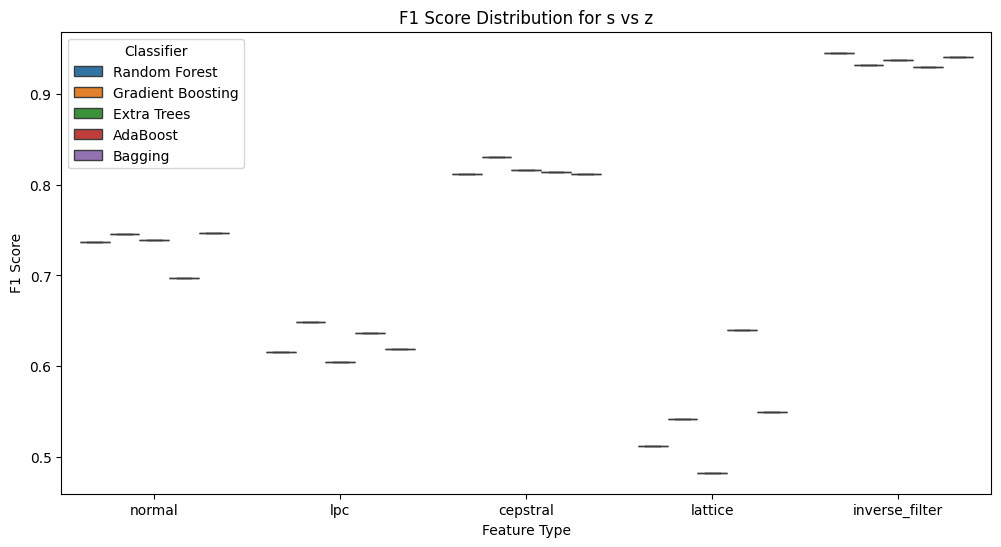

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter data for a specific class pair, e.g., "s vs z"
data_sz = df[df['Class Pair'] == 's vs z']

# Boxplot: compare F1 Score distributions for each Feature Type and Classifier.
plt.figure(figsize=(12, 6))
sns.boxplot(x='Feature Type', y='F1 Score', hue='Classifier', data=data_sz)
plt.title('F1 Score Distribution for s vs z')
plt.xlabel('Feature Type')
plt.ylabel('F1 Score')
plt.legend(title='Classifier')
plt.show()

In [56]:
def compute_average_metrics(df):
    avg_df = df.groupby("Feature Type")[["Accuracy", "Sensitivity", "Specificity", "F1 Score"]].mean().reset_index()
    avg_df.to_csv("average_metrics.csv", index=False)
    print("\nSaved: average_metrics.csv")
    return avg_df

csv_path="flattened_results.csv"
flattened_results = pd.read_csv(csv_path)
compute_average_metrics(flattened_results)


Saved: average_metrics.csv


,Feature Type,Accuracy,Sensitivity,Specificity,F1 Score
0,cepstral,0.803182,0.819659,0.786705,0.806760
1,inverse_filter,0.934545,0.945114,0.923977,0.935258
2,lattice,0.521932,0.587727,0.456136,0.546575
3,lpc,0.602841,0.594545,0.611136,0.599523
4,normal,0.795170,0.822955,0.767386,0.801655


In [57]:
from scipy.stats import t

def calculate_confidence_interval(data, confidence=0.95):
    n = len(data)
    mean = np.mean(data)
    margin = t.ppf((1 + confidence) / 2., n - 1) * sem(data)
    return mean, mean - margin, mean + margin

def compute_confidence_intervals(df):
    results = []
    for feature in df["Feature Type"].unique():
        feature_data = df[df["Feature Type"] == feature]
        for metric in ["Accuracy", "Sensitivity", "Specificity", "F1 Score"]:
            values = feature_data[metric].values
            mean, ci_low, ci_high = calculate_confidence_interval(values)
            results.append({
                "Feature Type": feature,
                "Metric": metric,
                "Mean": mean,
                "95% CI Lower": ci_low,
                "95% CI Upper": ci_high
            })
    ci_df = pd.DataFrame(results)
    ci_df.to_csv("confidence_intervals.csv", index=False)
    print("Saved: confidence_intervals.csv")
    return ci_df
df1 = pd.read_csv('average_metrics.csv')
df = pd.read_csv('flattened_results.csv')
"""calculate_confidence_interval(df) """
compute_confidence_intervals(df)

Saved: confidence_intervals.csv


,Feature Type,Metric,Mean,95% CI Lower,95% CI Upper
0,normal,Accuracy,0.795170,0.792792,0.797549
1,normal,Sensitivity,0.822955,0.821331,0.824578
2,normal,Specificity,0.767386,0.763986,0.770787
3,normal,F1 Score,0.801655,0.799544,0.803766
4,lpc,Accuracy,0.602841,0.601159,0.604523
5,lpc,Sensitivity,0.594545,0.592735,0.596356
6,lpc,Specificity,0.611136,0.608580,0.613693
7,lpc,F1 Score,0.599523,0.597911,0.601135
8,cepstral,Accuracy,0.803182,0.800839,0.805525
9,cepstral,Sensitivity,0.819659,0.817579,0.821739


In [58]:
def run_wilcoxon_test(df, feature1, feature2):
    results = []

    classifiers = df["Classifier"].unique()
    for clf in classifiers:
        df_clf = df[df["Classifier"] == clf]
        for metric in ["Accuracy", "Sensitivity", "Specificity", "F1 Score"]:
            values1 = df_clf[df_clf["Feature Type"] == feature1][metric].values
            values2 = df_clf[df_clf["Feature Type"] == feature2][metric].values

            if len(values1) == len(values2):  # Ensure pairing
                _, p_value = wilcoxon(values1, values2)
                results.append({
                    "Classifier": clf,
                    "Metric": metric,
                    "Feature Comparison": f"{feature1} vs {feature2}",
                    "P-Value": round(p_value, 4)
                })

    wilcoxon_df = pd.DataFrame(results)
    wilcoxon_df.to_csv("wilcoxon_test.csv", index=False)
    print("Saved: wilcoxon_test.csv")
    return wilcoxon_df


In [59]:
def get_top2_features(df, metric="Accuracy"):
    avg_df = df.groupby(["Feature Type"])[metric].mean().reset_index()
    top2 = avg_df.sort_values(by=metric, ascending=False)["Feature Type"].values[:2]
    return top2[0], top2[1]

In [60]:
flattened_results = pd.read_csv('flattened_results.csv')
f1, f2 = get_top2_features(flattened_results, metric="Accuracy")
wilcoxon_df = run_wilcoxon_test(flattened_results, feature1=f1, feature2=f2)

Saved: wilcoxon_test.csv


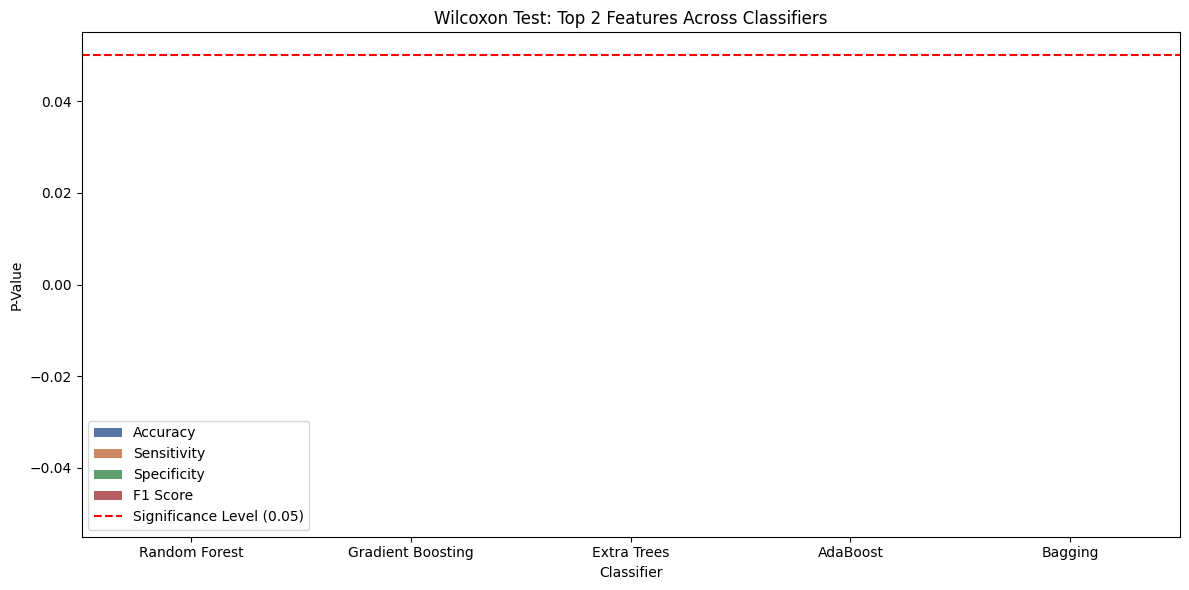

In [62]:
def plot_wilcoxon_results_all(csv_path="wilcoxon_test.csv"):
    df = pd.read_csv(csv_path)
    import seaborn as sns
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 6))
    sns.barplot(x="Classifier", y="P-Value", hue="Metric", data=df, palette="deep")  # Try "muted", "bright", "dark", etc.

    plt.axhline(0.05, linestyle="--", color="red", label="Significance Level (0.05)")
    plt.title("Wilcoxon Test: Top 2 Features Across Classifiers")
    plt.ylabel("P-Value")
    """plt.xticks(rotation=45)"""
    plt.legend()
    plt.tight_layout()
    plt.savefig("wilcoxon_all_classifiers.png", dpi=300)
    plt.show()
plot_wilcoxon_results_all()

In [63]:
def get_top_features(df, metric="Accuracy", top_n=5):
    avg_df = df.groupby(["Feature Type"])[metric].mean().reset_index()
    top_features = avg_df.sort_values(by=metric, ascending=False)["Feature Type"].values[:top_n]
    return top_features

In [64]:
from itertools import combinations

def run_wilcoxon_test(df, features):
    results = []

    classifiers = df["Classifier"].unique()
    for clf in classifiers:
        df_clf = df[df["Classifier"] == clf]
        for metric in ["Accuracy", "Sensitivity", "Specificity", "F1 Score"]:
            for feature1, feature2 in combinations(features, 2):  # Compare all pairs
                values1 = df_clf[df_clf["Feature Type"] == feature1][metric].values
                values2 = df_clf[df_clf["Feature Type"] == feature2][metric].values

                if len(values1) == len(values2):  # Ensure pairing
                    _, p_value = wilcoxon(values1, values2)
                    results.append({
                        "Classifier": clf,
                        "Metric": metric,
                        "Feature Comparison": f"{feature1} vs {feature2}",
                        "P-Value": round(p_value, 4)
                    })

    wilcoxon_df = pd.DataFrame(results)
    wilcoxon_df.to_csv("wilcoxon_test_results_all_classifiers.csv", index=False)
    print("Saved: wilcoxon_test_results_all_classifiers.csv")
    return wilcoxon_df

In [65]:
flattened_results = pd.read_csv('flattened_results.csv')
top_features = get_top_features(flattened_results, metric="Accuracy", top_n=5)
wilcoxon_df = run_wilcoxon_test(flattened_results, features=top_features)

Saved: wilcoxon_test_results_all_classifiers.csv


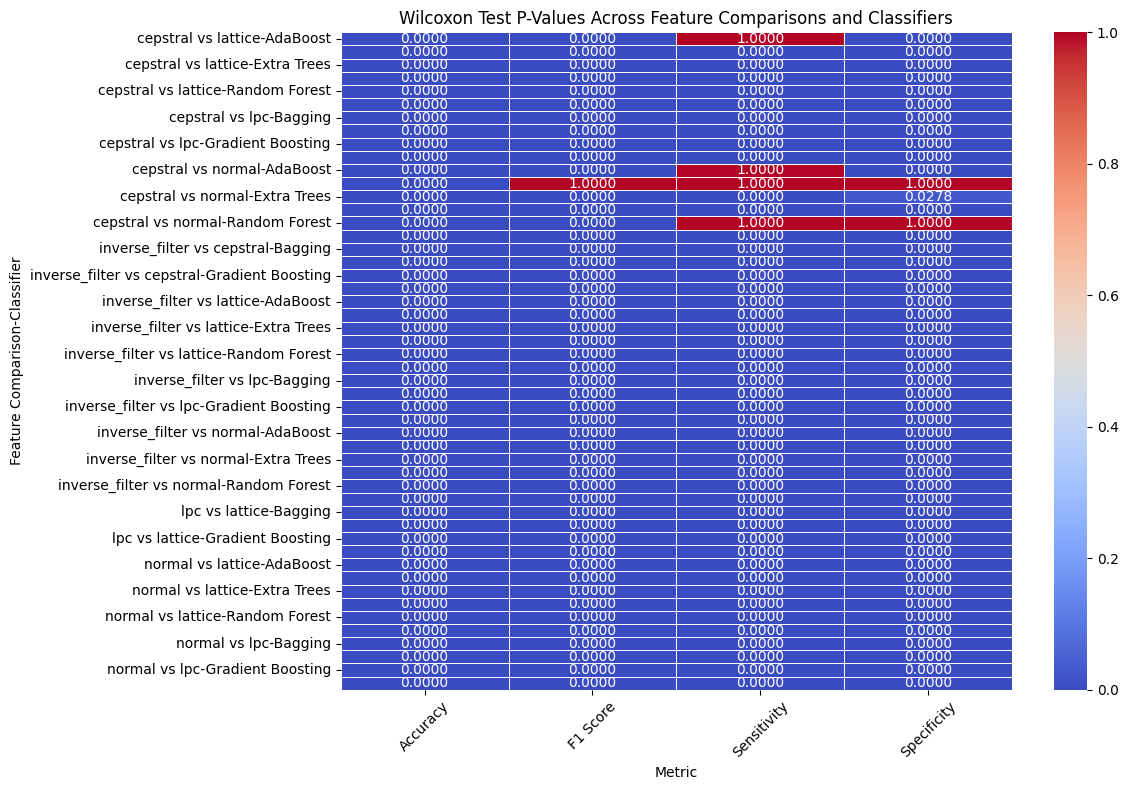

In [66]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("wilcoxon_test_results_all_classifiers.csv")

# Use pivot_table to handle duplicate index entries
heatmap_data = df.pivot_table(index=["Feature Comparison", "Classifier"], columns="Metric", values="P-Value", aggfunc="mean")

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", fmt=".4f", linewidths=0.5)

# Improve visibility
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.title("Wilcoxon Test P-Values Across Feature Comparisons and Classifiers")
plt.tight_layout()
plt.show()

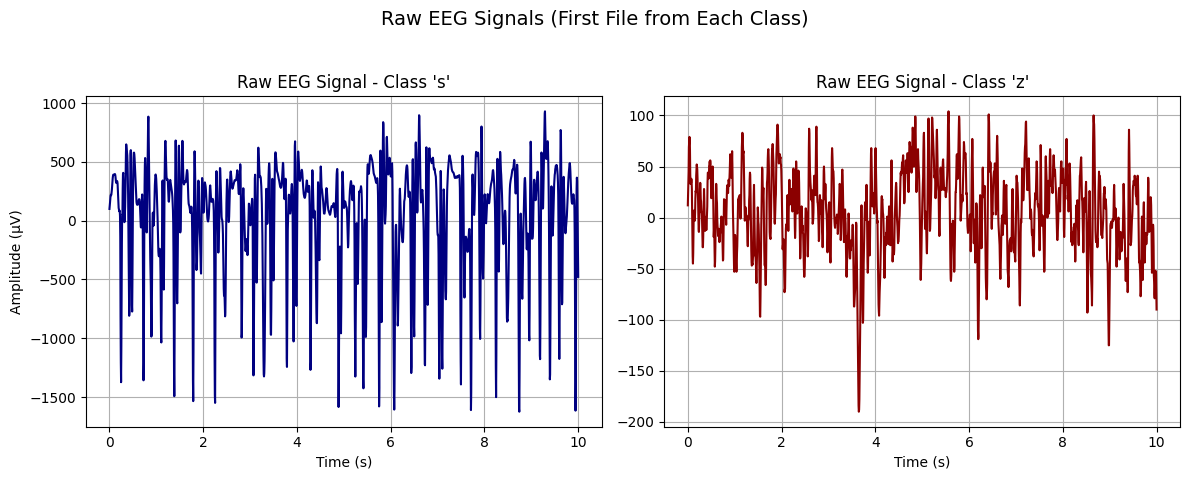

In [67]:
import matplotlib.pyplot as plt
import numpy as np
import os

def plot_raw_eeg_sample(class1='s', class2='z', fs=173.61, duration_sec=10):
    # Get one file from each class
    file1 = next(f for f in os.listdir(base_paths[class1]) if f.endswith('.txt'))
    file2 = next(f for f in os.listdir(base_paths[class2]) if f.endswith('.txt'))

    signal1 = np.loadtxt(os.path.join(base_paths[class1], file1))
    signal2 = np.loadtxt(os.path.join(base_paths[class2], file2))

    samples_to_plot = int(fs * duration_sec)
    t = np.linspace(0, duration_sec, samples_to_plot)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(t, signal1[:samples_to_plot], color='navy')
    plt.title(f"Raw EEG Signal - Class '{class1}'")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (µV)")
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(t, signal2[:samples_to_plot], color='darkred')
    plt.title(f"Raw EEG Signal - Class '{class2}'")
    plt.xlabel("Time (s)")
    plt.grid(True)

    plt.suptitle("Raw EEG Signals (First File from Each Class)", fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig("fig1_raw_eeg_signals.png", dpi=300)
    plt.show()
plot_raw_eeg_sample(class1='s', class2='z', fs=173.61, duration_sec=10)

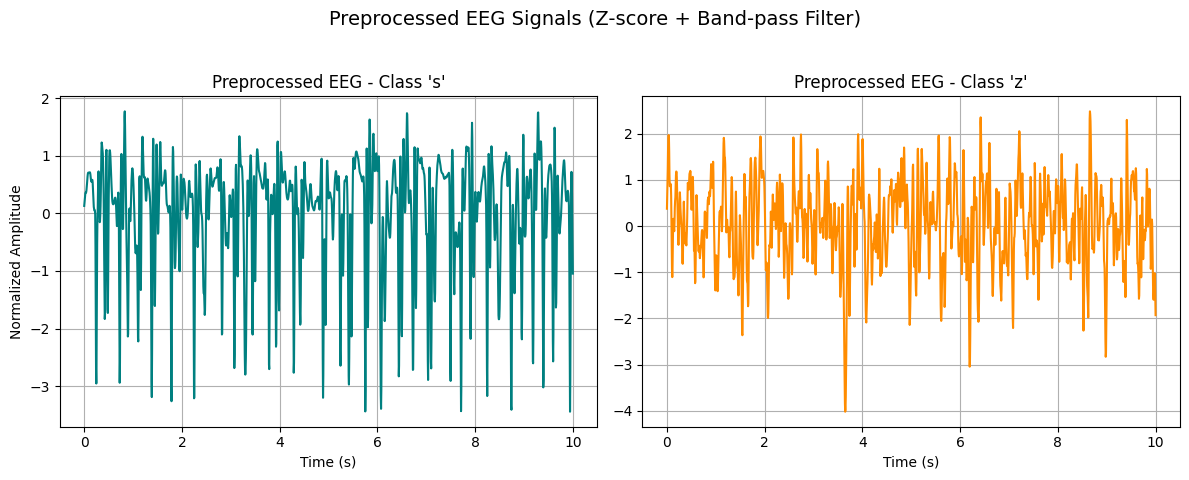

In [68]:
def plot_preprocessed_eeg_sample(class1='s', class2='z', fs=173.61, duration_sec=10):
    """
    Plots preprocessed EEG signals for first files in two given classes.

    Parameters:
        class1, class2 (str): Class labels (e.g., 's', 'z')
        fs (int): Sampling frequency in Hz
        duration_sec (int): Duration of signal to plot in seconds
    """
    from scipy.signal import butter, filtfilt, detrend
    from sklearn.preprocessing import StandardScaler

    def preprocess_signal(signal, lowcut=0.5, highcut=60.0, fs=173.61):
        # Remove DC drift
        signal = detrend(signal)

        # Band-pass filter
        nyq = 0.5 * fs
        b, a = butter(1, [lowcut / nyq, highcut / nyq], btype='band')
        filtered = filtfilt(b, a, signal)

        # Z-score normalization
        scaler = StandardScaler()
        normalized = scaler.fit_transform(filtered.reshape(-1, 1)).flatten()
        return normalized

    # Load same sample files as in Fig. 1
    file1 = next(f for f in os.listdir(base_paths[class1]) if f.endswith('.txt'))
    file2 = next(f for f in os.listdir(base_paths[class2]) if f.endswith('.txt'))

    signal1 = np.loadtxt(os.path.join(base_paths[class1], file1))
    signal2 = np.loadtxt(os.path.join(base_paths[class2], file2))

    # Apply preprocessing
    processed1 = preprocess_signal(signal1, fs=fs)
    processed2 = preprocess_signal(signal2, fs=fs)

    samples_to_plot = int(fs * duration_sec)  # Convert to integer
    t = np.linspace(0, duration_sec, int(samples_to_plot))  # Convert float to int

    # Plot
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(t, processed1[:samples_to_plot], color='teal')
    plt.title(f"Preprocessed EEG - Class '{class1}'")
    plt.xlabel("Time (s)")
    plt.ylabel("Normalized Amplitude")
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(t, processed2[:samples_to_plot], color='darkorange')
    plt.title(f"Preprocessed EEG - Class '{class2}'")
    plt.xlabel("Time (s)")
    plt.grid(True)

    plt.suptitle("Preprocessed EEG Signals (Z-score + Band-pass Filter)", fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig("fig2_preprocessed_eeg_signals.png", dpi=300)
    plt.show()
plot_preprocessed_eeg_sample(class1='s', class2='z', fs=173.61, duration_sec=10)

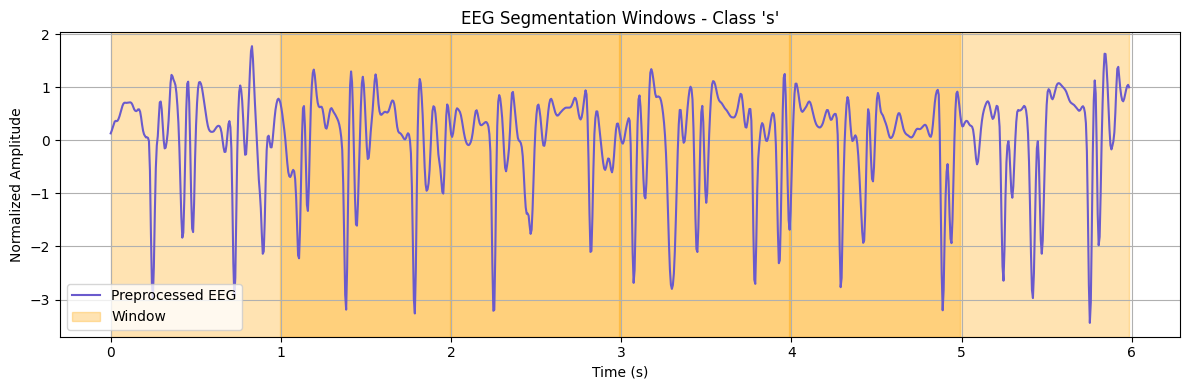

In [69]:
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.signal import butter, filtfilt, detrend
from sklearn.preprocessing import StandardScaler

def plot_segmentation_windows(class_label='s', fs=173.61, window_duration=2.0, overlap_duration=1.0, num_windows=5):
    def preprocess_signal(signal, lowcut=0.5, highcut=60.0, fs=173.61):
        # Detrend the signal
        signal = detrend(signal)
        # Band-pass filter
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(1, [low, high], btype='band')
        filtered = filtfilt(b, a, signal)
        # Normalize
        scaler = StandardScaler()
        return scaler.fit_transform(filtered.reshape(-1, 1)).flatten()

    # Load first EEG file from class
    file_name = next(f for f in os.listdir(base_paths[class_label]) if f.endswith('.txt'))
    raw = np.loadtxt(os.path.join(base_paths[class_label], file_name))
    signal = preprocess_signal(raw, fs=fs)

    # Segmentation parameters
    window_size = int(window_duration * fs)
    step_size = int(window_size - (overlap_duration * fs))
    samples_to_plot = (num_windows - 1) * step_size + window_size
    t = np.linspace(0, samples_to_plot / fs, samples_to_plot)

    # Plot signal
    plt.figure(figsize=(12, 4))
    plt.plot(t, signal[:samples_to_plot], color='slateblue', label='Preprocessed EEG')

    # Overlay segmentation windows
    for i in range(num_windows):
        start = i * step_size
        end = start + window_size
        plt.axvspan(start / fs, end / fs, color='orange', alpha=0.3, label='Window' if i == 0 else "")

    plt.title(f"EEG Segmentation Windows - Class '{class_label}'")
    plt.xlabel("Time (s)")
    plt.ylabel("Normalized Amplitude")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig("fig3_eeg_segmentation_windows.png", dpi=300)
    plt.show()
plot_segmentation_windows(class_label='s', fs=173.61, window_duration=2.0, overlap_duration=1.0, num_windows=5)

In [70]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_feature_distribution_boxplots(csv_path="flattened_results.csv", metric="Accuracy"):
    """
    Plots boxplots of a selected metric for each feature type.

    Parameters:
        csv_path (str): Path to the flattened metrics CSV.
        metric (str): The metric to plot ('Accuracy', 'F1 Score', etc.).
    """
    df = pd.read_csv(csv_path)

    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x="Feature Type", y=metric, palette="Set2")
    sns.stripplot(data=df, x="Feature Type", y=metric, color='black', alpha=0.4, jitter=0.15, size=2.5)

    plt.title(f"Distribution of {metric} Across Feature Types", fontsize=14)
    plt.ylabel(metric)
    plt.xlabel("Feature Type")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(f"fig4_feature_distribution_{metric.lower()}.png", dpi=300)
    plt.show()


C:\Users\RnR\AppData\Local\Temp\ipykernel_11564\3660580103.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Feature Type", y=metric, palette="Set2")


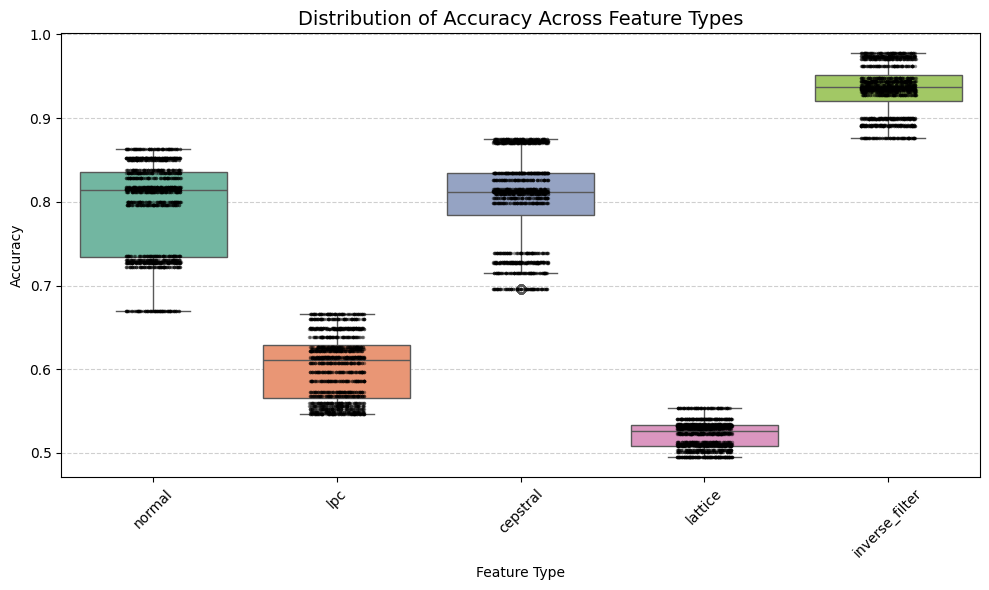

C:\Users\RnR\AppData\Local\Temp\ipykernel_11564\3660580103.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Feature Type", y=metric, palette="Set2")


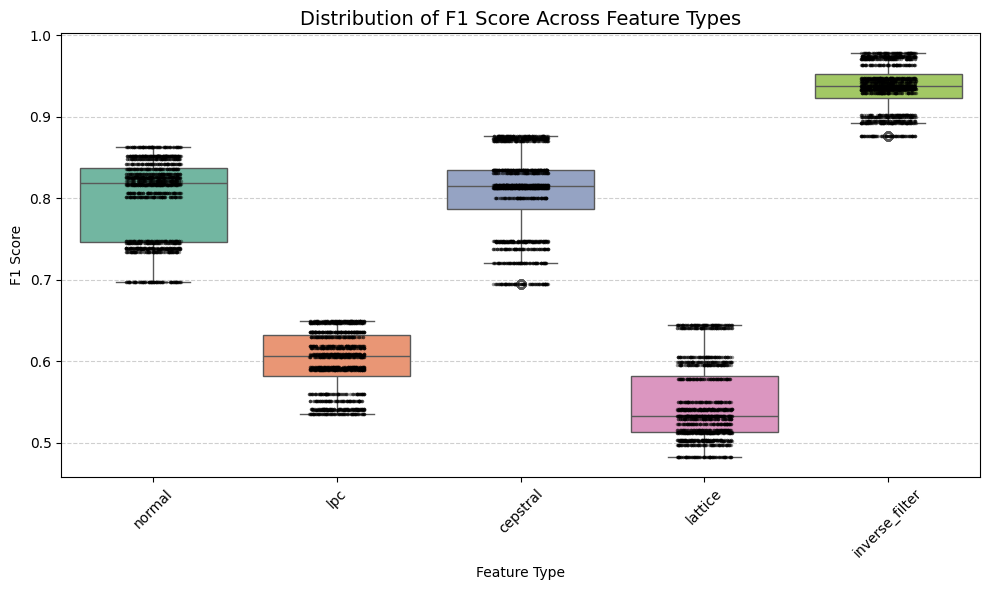

In [71]:
plot_feature_distribution_boxplots(metric="Accuracy")
plot_feature_distribution_boxplots(metric="F1 Score")


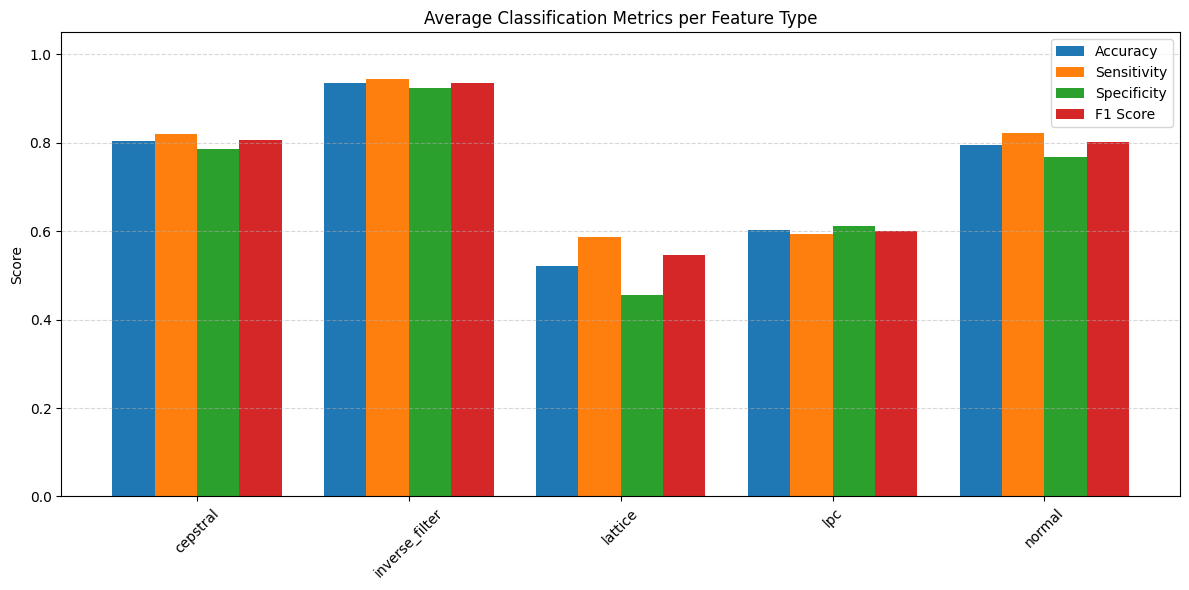

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_average_classification_metrics(csv_path="average_metrics.csv"):
    """
    Plots average classification metrics for each feature type.

    Parameters:
        csv_path (str): Path to CSV containing average metrics per feature type.
    """
    df = pd.read_csv(csv_path)

    metrics = ["Accuracy", "Sensitivity", "Specificity", "F1 Score"]
    feature_types = df["Feature Type"].tolist()
    bar_width = 0.2
    x = np.arange(len(feature_types))

    plt.figure(figsize=(12, 6))

    for i, metric in enumerate(metrics):
        plt.bar(x + i * bar_width, df[metric], width=bar_width, label=metric)

    plt.xticks(x + bar_width * 1.5, feature_types, rotation=45)
    plt.ylabel("Score")
    plt.title("Average Classification Metrics per Feature Type")
    plt.ylim(0, 1.05)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.savefig("fig5_average_metrics.png", dpi=300)
    plt.show()
plot_average_classification_metrics()

In [74]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_confidence_intervals(csv_path="confidence_intervals.csv", metric="Accuracy"):
    """
    Plots 95% confidence intervals for a given metric across all feature types.

    Parameters:
        csv_path (str): Path to CSV with mean and CI values.
        metric (str): Metric to plot ('Accuracy', 'F1 Score', etc.).
    """
    df = pd.read_csv(csv_path)
    df_metric = df[df["Metric"] == metric]

    feature_types = df_metric["Feature Type"]
    means = df_metric["Mean"]
    lower = df_metric["95% CI Lower"]
    upper = df_metric["95% CI Upper"]

    errors = [means - lower, upper - means]

    plt.figure(figsize=(10, 6))
    plt.bar(feature_types, means, yerr=errors, capsize=6, color='skyblue', edgecolor='black')
    plt.ylabel(metric)
    plt.xlabel("Feature Type")
    plt.title(f"{metric} with 95% Confidence Intervals")
    plt.ylim(0, 1.05)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(f"fig6_confidence_intervals_{metric.lower()}.png", dpi=300)
    plt.show()


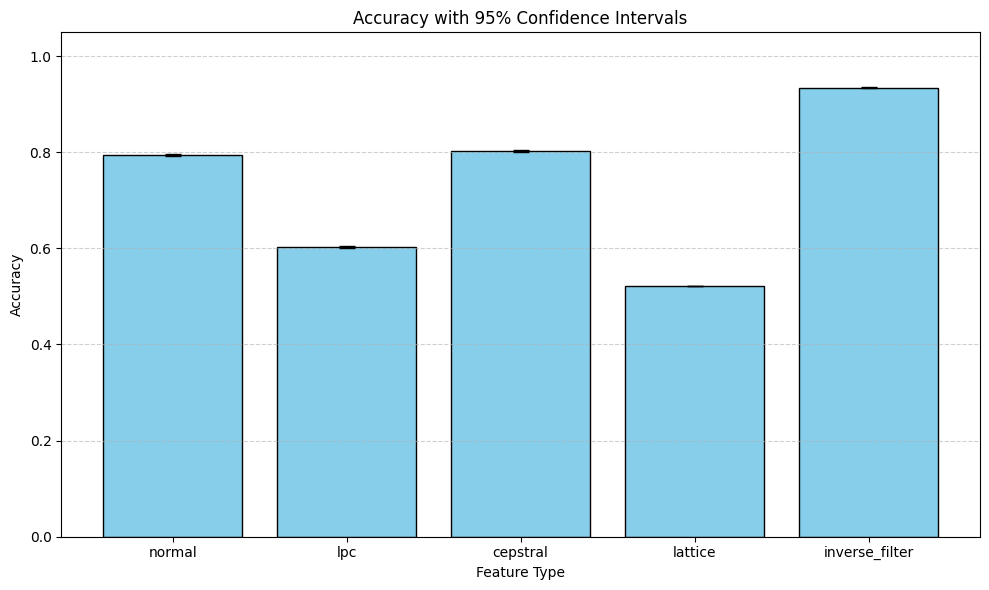

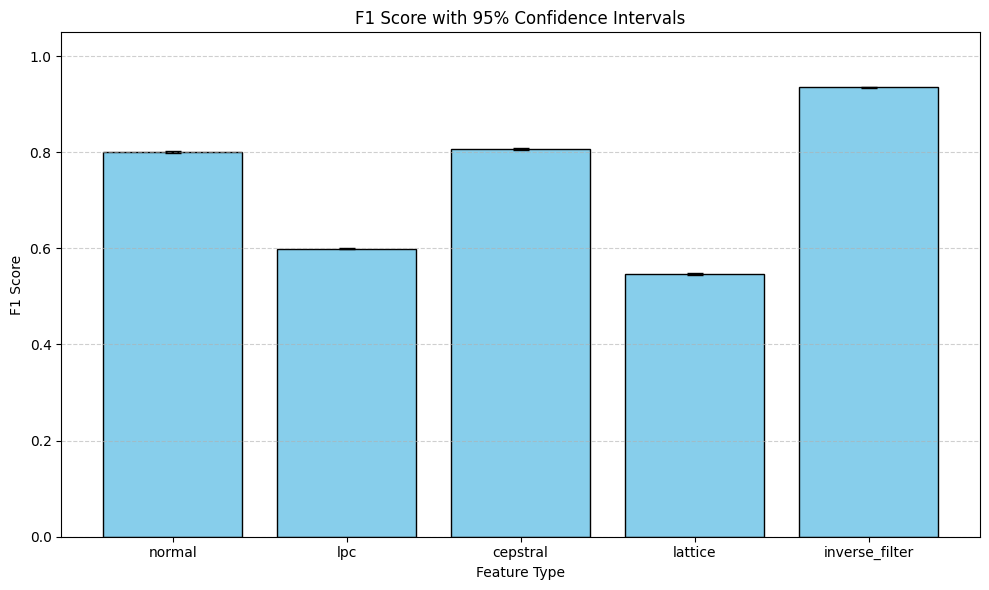

In [75]:
plot_confidence_intervals(metric="Accuracy")
plot_confidence_intervals(metric="F1 Score")


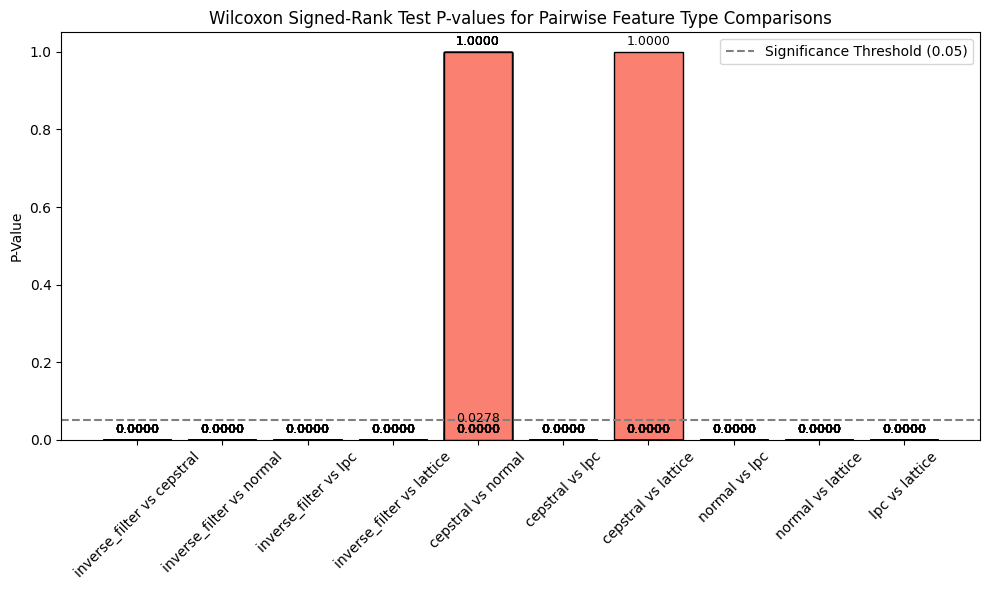

In [80]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_wilcoxon_p_values(csv_path="wilcoxon_test_results_all_classifiers.csv"):
    """
    Plots bar chart of Wilcoxon test p-values for feature comparison.

    Parameters:
        csv_path (str): CSV file with p-values from Wilcoxon test.
    """
    df = pd.read_csv(csv_path)

    plt.figure(figsize=(10, 6))
    bars = plt.bar(df["Feature Comparison"], df["P-Value"], color='salmon', edgecolor='black')

    # Highlight significance threshold
    plt.axhline(y=0.05, color='gray', linestyle='--', label='Significance Threshold (0.05)')

    # Add p-value labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f"{height:.4f}",
                 ha='center', va='bottom', fontsize=9)

    plt.title("Wilcoxon Signed-Rank Test P-values for Pairwise Feature Type Comparisons")
    plt.ylabel("P-Value")
    plt.xticks(rotation=45)
    plt.ylim(0, 1.05)
    plt.legend()
    plt.tight_layout()
    plt.savefig("fig7_wilcoxon_p_values.png", dpi=300)
    plt.show()
plot_wilcoxon_p_values()

In [77]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

def plot_inverse_filter_feature_importance(segment_cache, class1='s', class2='z', feature_type='inverse_filter'):
    """
    Trains a Random Forest on Inverse Filter features and plots feature importance.

    Parameters:
        segment_cache (dict): Preprocessed and segmented data cache.
        class1, class2 (str): Class labels to compare.
        feature_type (str): Feature type to analyze.
    """
    from sklearn.metrics import classification_report

    segments, labels = [], []

    for label in [class1, class2]:
        s, l = segment_cache[label]
        segments.extend(s)
        labels.extend(l)

    label_map = {class1: 0, class2: 1}
    y = np.array([label_map[lbl] for lbl in labels])

    # Extract inverse filter features
    feature_data = []
    for seg in segments:
        values, _ = extract_features_by_type_nan(seg, feature_type)
        feature_data.append(values)

    X = np.array(feature_data)
    imputer = SimpleImputer(strategy='mean')
    X = imputer.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)

    importances = clf.feature_importances_
    feature_names = ["Mean", "Variance", "Entropy", "PseudoCov", "i-e-k Cov"]

    # Plot
    plt.figure(figsize=(8, 5))
    bars = plt.barh(feature_names, importances, color='mediumseagreen', edgecolor='black')
    plt.xlabel("Importance Score")
    plt.title("Random Forest Feature Importance – Inverse Filter")
    plt.gca().invert_yaxis()
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig("fig8_inverse_filter_feature_importance.png", dpi=300)
    plt.show()

    print("Classification Performance:\n", classification_report(y_test, clf.predict(X_test)))


2025-05-08 14:02:12,159 - INFO - Loading EEG data from: D:\RESEARCH\DATABASE\Bonn Univ Dataset\s\S
2025-05-08 14:02:12,356 - INFO - Loaded 100 EEG files from D:\RESEARCH\DATABASE\Bonn Univ Dataset\s\S
2025-05-08 14:02:12,357 - INFO - Segmenting & preprocessing EEGs for label: s
2025-05-08 14:02:12,616 - INFO - CACHED: s with 2200 segments
2025-05-08 14:02:12,617 - INFO - Loading EEG data from: D:\RESEARCH\DATABASE\Bonn Univ Dataset\z\Z
2025-05-08 14:02:12,808 - INFO - Loaded 100 EEG files from D:\RESEARCH\DATABASE\Bonn Univ Dataset\z\Z
2025-05-08 14:02:12,810 - INFO - Segmenting & preprocessing EEGs for label: z
2025-05-08 14:02:13,057 - INFO - CACHED: z with 2200 segments


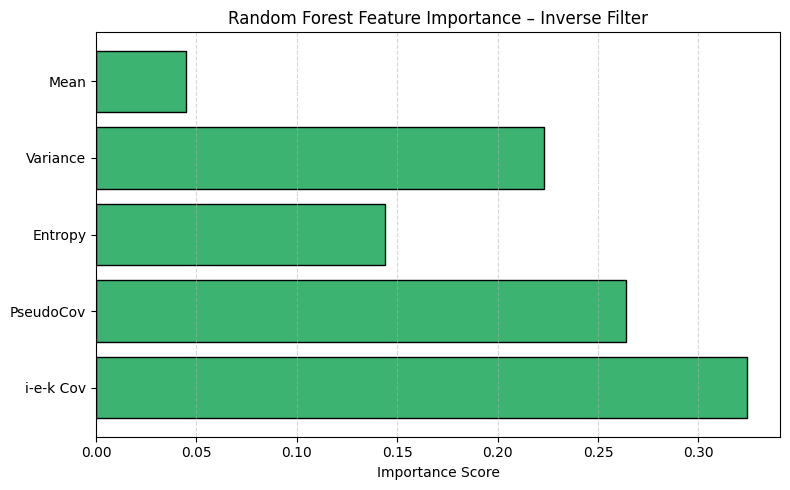

Classification Performance:
               precision    recall  f1-score   support

           0       0.97      0.92      0.94       440
           1       0.92      0.97      0.95       440

    accuracy                           0.94       880
   macro avg       0.95      0.94      0.94       880
weighted avg       0.95      0.94      0.94       880



In [78]:
segment_cache = preprocess_and_segment_all_classes(['s', 'z'])
plot_inverse_filter_feature_importance(segment_cache, class1='s', class2='z')


In [79]:
import pandas as pd
import numpy as np

# === Table 1: Average Classification Metrics with 95% CI ===
def generate_table_1(avg_path="average_metrics.csv", ci_path="confidence_intervals.csv"):
    avg_df = pd.read_csv(avg_path)
    ci_df = pd.read_csv(ci_path)

    table1 = []
    for feature in avg_df["Feature Type"]:
        row = {"Feature Type": feature}
        for metric in ["Accuracy", "Sensitivity", "Specificity", "F1 Score"]:
            mean = ci_df[(ci_df["Feature Type"] == feature) & (ci_df["Metric"] == metric)]["Mean"].values[0]
            ci_low = ci_df[(ci_df["Feature Type"] == feature) & (ci_df["Metric"] == metric)]["95% CI Lower"].values[0]
            ci_high = ci_df[(ci_df["Feature Type"] == feature) & (ci_df["Metric"] == metric)]["95% CI Upper"].values[0]
            row[metric] = f"{mean:.3f} ± {abs(ci_high - mean):.3f}"
        table1.append(row)

    df1 = pd.DataFrame(table1)
    df1.to_csv("table1_avg_metrics_with_ci.csv", index=False)
    return df1


# === Table 2: Wilcoxon Signed-Rank Test Results ===
def generate_table_2(wilcoxon_path="wilcoxon_test_results_all_classifiers.csv"):
    df2 = pd.read_csv(wilcoxon_path)
    df2.to_csv("table2_wilcoxon_results.csv", index=False)
    return df2


# === Table 3: Sample Feature Values for One Segment ===
def generate_table_3(flattened_path="flattened_results.csv"):
    df = pd.read_csv(flattened_path)
    sample_rows = df[df["Feature Type"] == "inverse_filter"].head(1)
    df3 = sample_rows[["Class Pair", "Feature Type", "Accuracy", "Sensitivity", "Specificity", "F1 Score"]]
    df3.to_csv("table3_sample_inverse_filter_metrics.csv", index=False)
    return df3


# === Table 4: Classifier-wise Performance (Optional Detail Table) ===
def generate_table_4(raw_output):
    """
    This requires collecting classifier-wise data before flattening.
    If you have it stored per classifier, this function can organize it.
    Placeholder for now unless explicitly logged.
    """
    print("⚠️ Table 4 requires structured raw classifier-wise output. Skipped.")
    return None


# === Table 5: Feature Extraction Time (Optional if tracked) ===
def generate_table_5(feature_timing_dict=None):
    """
    feature_timing_dict: dict like {'normal': 3.1, 'lpc': 4.6, ...}
    """
    if feature_timing_dict is None:
        print("⚠️ Table 5 requires timing data during feature extraction. Skipped.")
        return None
    df5 = pd.DataFrame([
        {"Feature Type": k, "Computation Time (s)": v} for k, v in feature_timing_dict.items()
    ])
    df5.to_csv("table5_feature_extraction_times.csv", index=False)
    return df5


# === Call All Tables ===
def generate_all_tables():
    print("✅ Generating Table 1...")
    t1 = generate_table_1()
    print("✅ Generating Table 2...")
    t2 = generate_table_2()
    print("✅ Generating Table 3...")
    t3 = generate_table_3()
    print("✅ Table 4 requires structured raw classifier-wise results.")
    print("✅ Table 5 requires feature timing logs (optional).")
    return t1, t2, t3

# Run all
t1, t2, t3 = generate_all_tables()


✅ Generating Table 1...
✅ Generating Table 2...
✅ Generating Table 3...
✅ Table 4 requires structured raw classifier-wise results.
✅ Table 5 requires feature timing logs (optional).


In [81]:
import sys
import pkg_resources

print(f"Python Version: {sys.version}")
print("Installed Packages:")
for package in pkg_resources.working_set:
    print(f"{package.project_name}=={package.version}")

C:\Users\RnR\AppData\Local\Temp\ipykernel_11564\4241138478.py:2: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


Python Version: 3.13.1 (tags/v3.13.1:0671451, Dec  3 2024, 19:06:28) [MSC v.1942 64 bit (AMD64)]
Installed Packages:
Cython==3.0.12
MarkupSafe==3.0.2
PyYAML==6.0.2
Send2Trash==1.8.3
anyio==4.9.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
arrow==1.3.0
asttokens==3.0.0
async-lru==2.0.5
attrs==25.3.0
babel==2.17.0
beautifulsoup4==4.13.3
bleach==6.2.0
certifi==2025.1.31
cffi==1.17.1
charset-normalizer==3.4.1
clifford==1.4.0
colorama==0.4.6
comm==0.2.2
contourpy==1.3.1
cycler==0.12.1
debugpy==1.8.13
decorator==5.2.1
defusedxml==0.7.1
executing==2.2.0
fastjsonschema==2.21.1
fonttools==4.55.3
fqdn==1.5.1
galgebra==0.5.2
h11==0.14.0
h5py==3.12.1
httpcore==1.0.7
httpx==0.28.1
idna==3.10
imbalanced-learn==0.13.0
ipykernel==6.29.5
ipython==9.1.0
ipython-pygments-lexers==1.1.1
isoduration==20.11.0
jedi==0.19.2
jinja2==3.1.6
joblib==1.4.2
json5==0.12.0
jsonpointer==3.0.0
jsonschema==4.23.0
jsonschema-specifications==2024.10.1
jupyter-client==8.6.3
jupyter-core==5.7.2
jupyter-events==0.12.0
ju

In [82]:
import numpy
import pandas
import sklearn

print(f"Numpy Version: {numpy.__version__}")
print(f"Pandas Version: {pandas.__version__}")
print(f"Scikit-learn Version: {sklearn.__version__}")

Numpy Version: 2.2.5
Pandas Version: 2.2.3
Scikit-learn Version: 1.6.1


In [83]:
import platform
import psutil

print(f"Processor: {platform.processor()}")
print(f"Machine: {platform.machine()}")
print(f"RAM: {psutil.virtual_memory().total / 1e9:.2f} GB")

Processor: Intel64 Family 6 Model 154 Stepping 3, GenuineIntel
Machine: AMD64
RAM: 16.87 GB
